# MORDM Dike Model
This Notebook focusses on directed search of policy solutions and robustness evaluation, and it devised to be used after the scenario discovery notebook has run. Directed search, for this analysis, consists of MORDM - which in turn consists of MOEA (Many Objective Evolutionary Algorithm) to find candidate policies in the lever space based on a reference scenario, and robustness analysis to evaluate the impact of deep uncertainty on the candidate policies. 

The notebook is structured as follows:
* Import of libraries & Definition of model input and model
* Optimization over lever space
* Reduction of pareto set of candiate policies at hand criteria-extent distribution
* Robustness analysis of candidate policies under deep uncertainty
* Vulnerability analysis of canditate solutions

## Import of libraries & Definition of model input and model

The required libraries to run this notebook are:

* ema_workbench
* platypus
* numpy
* pandas
* matplotlib.pyplot
* __future__
* problem_formulation (.py-file of the model)

In [6]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import (unicode_literals, print_function, absolute_import, division)

from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, ScalarOutcome, Policy,
                           RealParameter, CategoricalParameter, IntegerParameter, optimize, Scenario)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties, LHSSampler
from ema_workbench.em_framework.salib_samplers import SobolSampler, MorrisSampler
from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim

from problem_formulation import get_model_for_problem_formulation

# parameter definition for visualization libraries
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

In [7]:
#name the specific dikes
dikes = [f"A.{i+1}" for i in range(5)]

#problem formulation selection
pf = 3

#Dependent on problem formulation used, outcomes are defined

if pf == 3:
    outcomes = []
    for dike in dikes:
        outcomes.append(ScalarOutcome(f'{dike}_Expected Annual Damage', kind=ScalarOutcome.MINIMIZE))
        outcomes.append(ScalarOutcome(f'{dike}_Dike Investment Costs', kind=ScalarOutcome.MINIMIZE))
        outcomes.append(ScalarOutcome(f'{dike}_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE))
        #outcomes_single.append(ScalarOutcome(f'{dike} Total Costs', kind=ScalarOutcome.MINIMIZE))

    #append to the outcomes list
    outcomes.append(ScalarOutcome('RfR Total Costs', kind=ScalarOutcome.MINIMIZE))
    outcomes.append(ScalarOutcome('Expected Evacuation Costs', kind=ScalarOutcome.MINIMIZE))

#other items commented out to fit with above
if pf == 4:
    outcomes_single = []
    outcomes_lists = []
    for dike in dikes:
        outcomes_lists.append([ScalarOutcome(f'{dike}_Expected Annual Damage {n}', kind=ScalarOutcome.MINIMIZE) for n in range(3)])
        outcomes_lists.append([ScalarOutcome(f'{dike}_Dike Investment Costs {n}', kind=ScalarOutcome.MINIMIZE) for n in range(3)])
        outcomes_lists.append([ScalarOutcome(f'{dike}_Expected Number of Deaths {n}', kind=ScalarOutcome.MINIMIZE) for n in range(3)])
        #outcomes_single.append(ScalarOutcome(f'{dike} Total Costs', kind=ScalarOutcome.MINIMIZE))

    outcomes_lists.append([ScalarOutcome(f'RfR Total Costs {n}', kind=ScalarOutcome.MINIMIZE) for n in range(3)])
    outcomes_lists.append([ScalarOutcome(f'Expected Evacuation Costs {n}', kind=ScalarOutcome.MINIMIZE) for n in range(3)])

    #append to the outcomes list
    outcomes = [*outcomes_single]
    for outcome_list in outcomes_lists:
        for outcome in outcome_list:
            outcomes.append(outcome)

In [8]:
# Uncertainties are defined uniformous, independent of problem formulation
uncertainties = [IntegerParameter('A.0_ID flood wave shape', 0, 133),
                   RealParameter('A.1_Bmax', 30,350),
                   CategoricalParameter('A.1_Brate',(0.9,1.5,1000)),
                   RealParameter('A.1_pfail',0,1),
                   RealParameter('A.2_Bmax', 30,350),
                   CategoricalParameter('A.2_Brate',(0.9,1.5,1000)),
                   RealParameter('A.2_pfail',0,1),
                   RealParameter('A.3_Bmax', 30,350),
                   CategoricalParameter('A.3_Brate',(0.9,1.5,1000)),
                   RealParameter('A.3_pfail',0,1),
                   RealParameter('A.4_Bmax', 30,350),
                   CategoricalParameter('A.4_Brate',(0.9,1.5,1000)),
                   RealParameter('A.4_pfail',0,1),
                   RealParameter('A.5_Bmax', 30,350),
                   CategoricalParameter('A.5_Brate',(0.9,1.5,1000)),
                   RealParameter('A.5_pfail',0,1),
                   CategoricalParameter('discount rate 1',(1.5,2.5,3.5,4.5)),
                   CategoricalParameter('discount rate 2',(1.5,2.5,3.5,4.5))]

In [9]:
# Analogous to uncertainties model levers are defined
levers = [IntegerParameter('A.1_DikeIncrease',0,10),
                     IntegerParameter('A.2_DikeIncrease',0,10),
                     IntegerParameter('A.3_DikeIncrease',0,10),
                     IntegerParameter('A.4_DikeIncrease',0,10),
                     IntegerParameter('A.5_DikeIncrease',0,2), #capped this variable to test if the model uses these specified levers
                     IntegerParameter('1_RfR 0',0,1),
                     IntegerParameter('2_RfR 0',0,1),
                     IntegerParameter('3_RfR 0',0,1),
                     IntegerParameter('4_RfR 0',0,1),
                     IntegerParameter('0_RfR 0',0,1),
                     IntegerParameter('EWS_DaysToThreat',0,4)]

In [10]:
if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)

    dike_model, function_planning_steps = get_model_for_problem_formulation(pf)

    #setting up the reference scenario - needed for MORDM
    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'discount rate': 3.5,
                        'ID flood wave shape': 4}
    
    # Definition of scenario-dictionary for later creation of policy class-instance for reference scenario 
    scen1 = {}

    # reference scenario updated for all dike rings
    for key in dike_model.uncertainties:
        name_split = key.name.split('_')
        if len(name_split) == 1:
            if key.name in reference_values.keys():
                scen1.update({key.name: reference_values[name]})
        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    #setting so that the reference scenario
    ref_scenario = Scenario('reference', **scen1)
    
    #setting up dike model uncertainties and potential ranges
    dike_model.uncertainties = uncertainties

    # set levers
    dike_model.levers = levers

    # set convergence metrics
    convergence_metrics = [EpsilonProgress()]
    
    # set nfe
    nfe = 100000

## Optimization over lever space

For the model defined above, optimization is run to conducted direct search over the policy space.
After candidate policies have been found, the tradeoff between outputs in the reference scenario are present across parallel coordinate graphs

In [7]:
# run optimization
# with MultiprocessingEvaluator(dike_model) as evaluator:
#         results, convergence = evaluator.optimize(nfe=nfe,
#                                                   searchover='levers',
#                                                   epsilons=[0.1,]*len(dike_model.outcomes),
#                                                   convergence=convergence_metrics,
#                                                   reference=ref_scenario
#                                                   )

In [123]:
#done on another machine and imported here due to computational power
results = pd.read_csv("results/results_convergence_robustness_40000.csv")

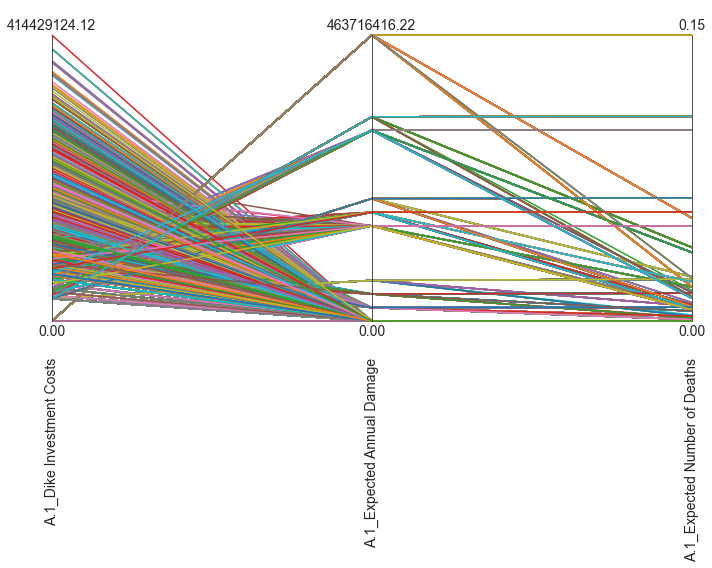

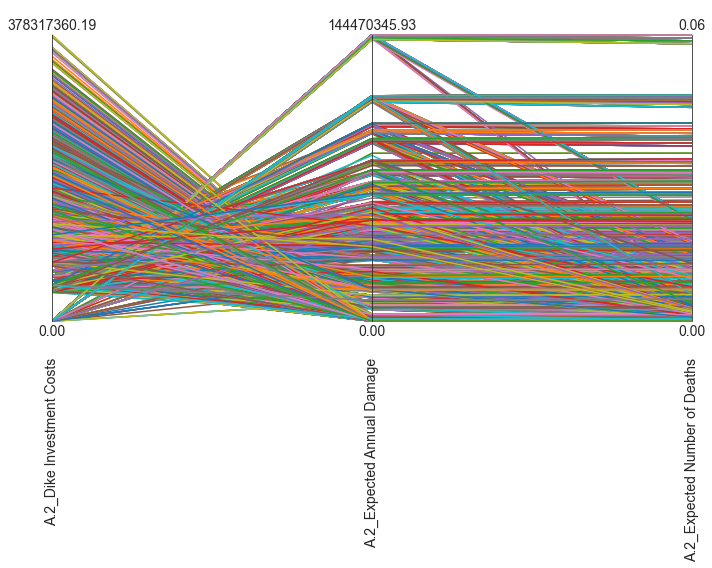

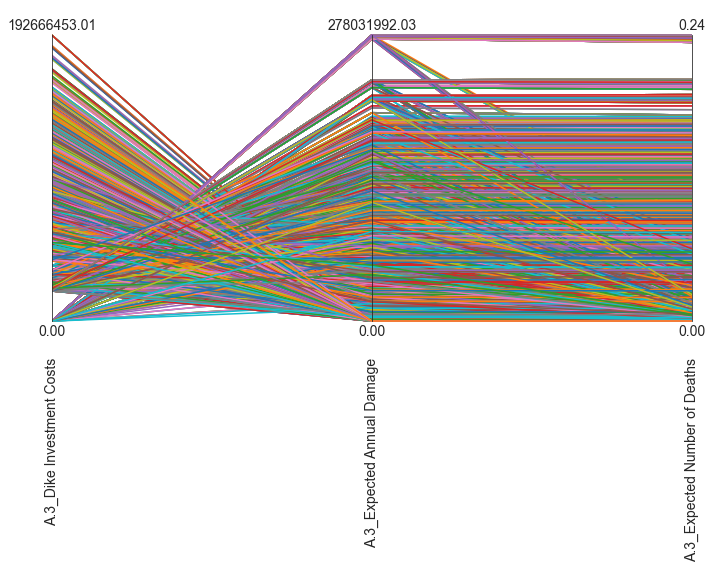

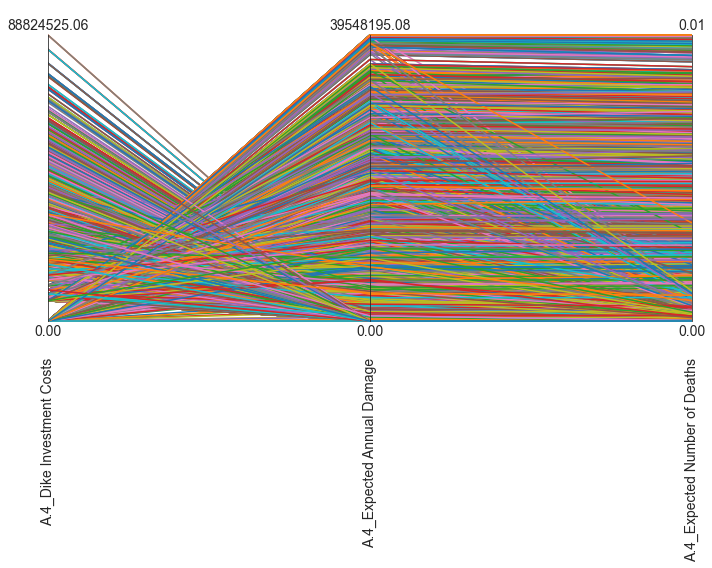

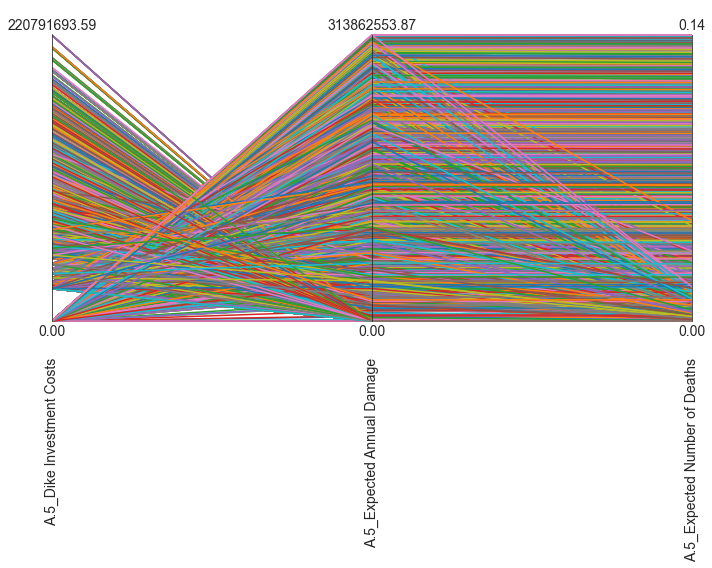

In [125]:
#gives results across each of the dike rings for problem_formulation (3)
for i in range(5):

        data = results.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        #paraxes.invert_axis('max_P')
        plt.show()
        #plt.savefig(f"parcords_dikering_A.{i+1}.png", dpi=300)

## Reduction of pareto set of candiate policies at hand criteria-extent distribution

With our given pareto-set of policy solutions, we know there remain no trade-off improvements in individual outcomes extents. However, given the large amount of outcomes, we still do have a very large set of potential  policy solutions. This for robustness analysis, with which we aim to choose between a small set of policies, constitutes an issue. 

To reduce our policy set we choose the best performing policies in aggregate outcomes. These are created an ranked as follows:

* Deaths in Gelderland
* Damages in Gelderland
* Investment of Gelderland 

We deem arbitrarily defined threshold as a rather bad apporach. Alternatively, we rank our policies by the aggregated outcomes, and then proceed to take the top 10% per outcome. This is performed iteratively over the different outcomes. This way we ensure that our policies are not selected by being over or under an arbitrary threshold, but actually outperform their competing policies in the considered outcome, before being weeded out further for the following outcomes.

In [10]:
#Create aggregate columns for death, damage and investment cost
results["Gelderland_Deaths"] = results[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
results["Gelderland_Damages"] = results[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
results["Gelderland_Investment"] = results[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)

#Set threshiold for priority 1, 2 and 3: Deaths, Damages and Investment costs
distribution_threshold_deaths = 0.1
distribution_threshold_damages = 0.1
distribution_threshold_investment = 0.1

#Refine Policies-Dataframe to fit Priority 1 criterion
results2 = results.sort_values("Gelderland_Deaths")
results2 = results.iloc[0:int(len(results2)*distribution_threshold_deaths),:]

#Refine Policies-Dataframe to fit Priority 2 criterion
results3 = results2.sort_values("Gelderland_Damages")
results3 = results3.iloc[0:int(len(results3)*distribution_threshold_damages),:]

#Refine Policies-Dataframe to fit Priority 3 criterion
results4 = results3.sort_values("Gelderland_Investment")
policies = results4.iloc[0:int(len(results4)*distribution_threshold_investment),:]

policies

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment
823,823,1,0,0,0,1,0,1,0,1,...,4.960951e+07,0.000000,2.402613e+08,2.503721e+07,0.037760,3.638000e+08,3461.354794,0.0,0.0,1.947789e+08
380,380,0,0,1,0,1,0,0,0,0,...,2.440235e+07,0.000000,1.724411e+08,6.668707e+07,0.075193,8.146000e+08,0.000000,0.0,0.0,2.700498e+08
348,348,0,0,1,1,1,1,0,0,0,...,0.000000e+00,0.002666,4.884783e+07,7.484361e+07,0.021066,1.627500e+09,0.000000,0.0,0.0,2.706672e+08
249,249,0,0,1,1,0,1,0,1,1,...,3.321792e+07,0.000028,0.000000e+00,1.556831e+08,0.000000,1.080100e+09,30.051070,0.0,0.0,2.721397e+08
328,328,0,1,0,1,1,1,0,0,1,...,1.634729e+07,0.002214,9.324194e+07,4.027367e+07,0.040054,1.146000e+09,0.000000,0.0,0.0,3.023406e+08
361,361,0,1,1,0,0,0,1,0,1,...,2.511400e+07,0.000209,1.650635e+07,1.142676e+08,0.007301,2.306000e+08,0.000000,0.0,0.0,3.109646e+08
206,206,0,1,0,1,0,1,0,0,1,...,2.652764e+07,0.000000,1.035444e+08,3.337712e+07,0.044859,6.721000e+08,0.000000,0.0,0.0,3.127653e+08
118,118,1,0,0,0,1,0,0,0,0,...,3.114947e+07,0.000000,2.121884e+08,3.337712e+07,0.033229,8.146000e+08,3066.158417,0.0,0.0,3.166069e+08
741,741,0,0,0,1,1,1,0,1,0,...,2.078505e+07,0.001611,0.000000e+00,1.773532e+08,0.000000,1.196300e+09,0.000000,0.0,0.0,3.321870e+08


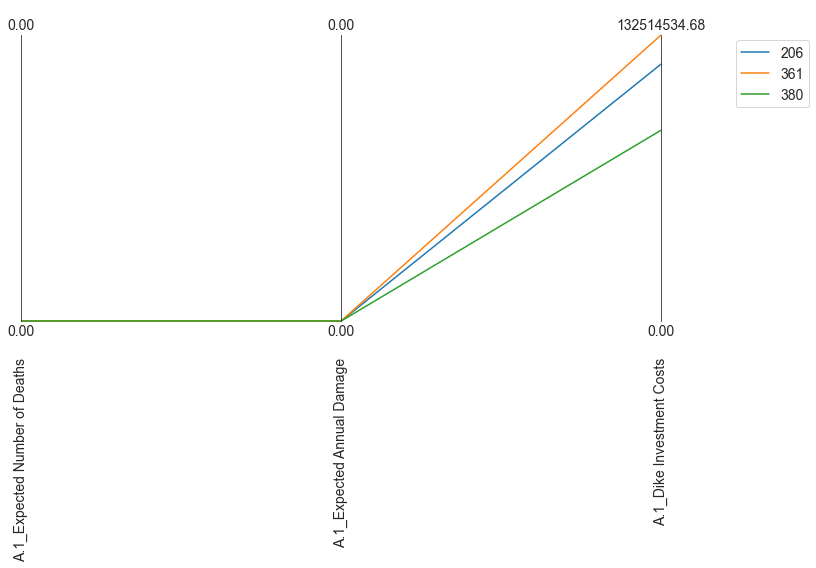

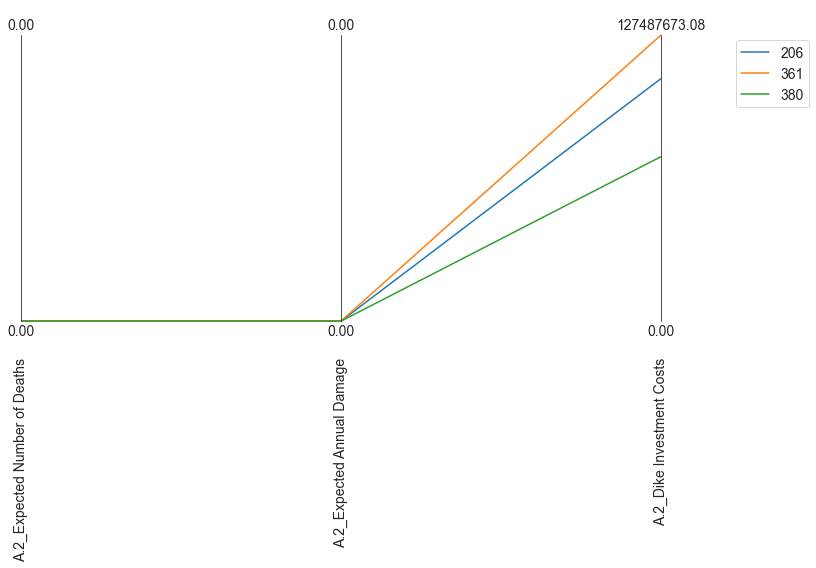

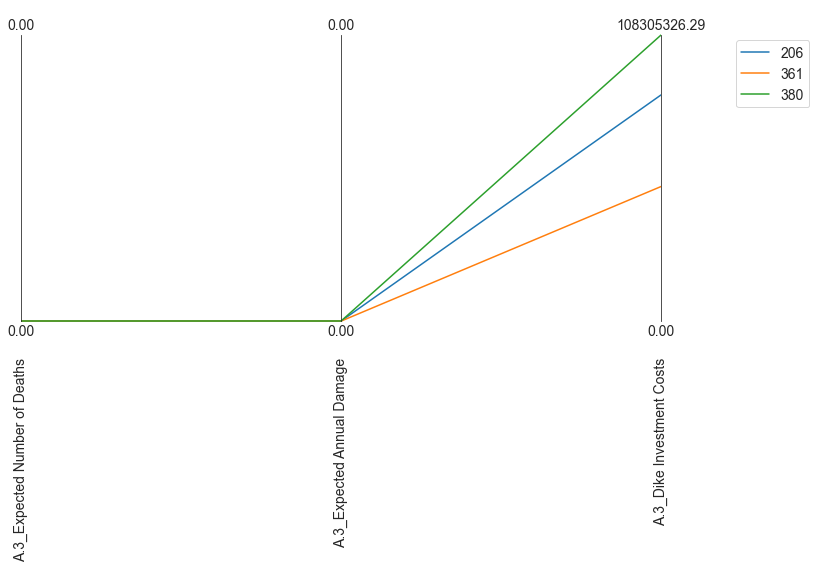

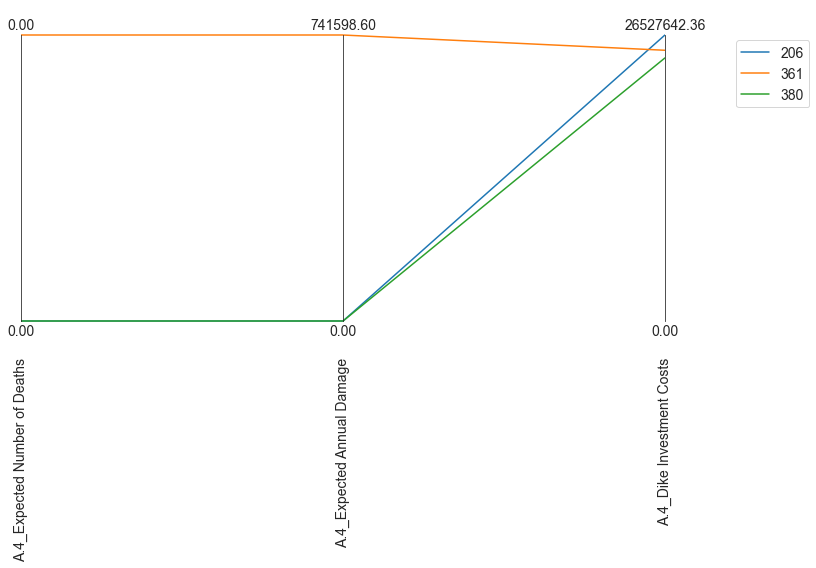

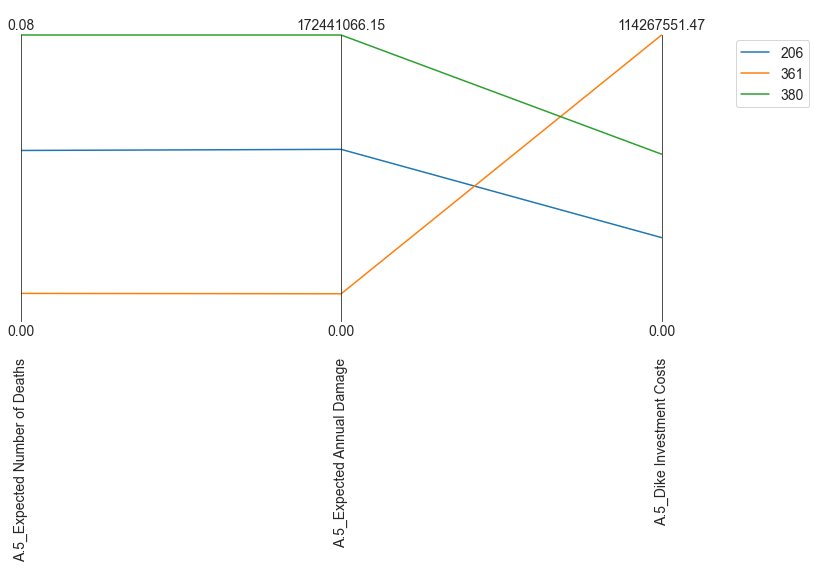

In [129]:
for i in range(5):

        data = policies.loc[:, [f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Expected Annual Damage",                               
                               f"A.{i+1}_Dike Investment Costs",
                               ]].iloc[[1,5,6],:]
        data = data.sort_index()
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        for j, (ind, row) in enumerate(data.reset_index().iterrows()):
            paraxes.plot(row.to_frame().T, label=int(row['index']), color=colors[j])
        paraxes.legend()
        plt.savefig(f"parcoords_ tradeoff_base-scenario_policies A.{i+1}_political_team.png", dpi=300)
        plt.show()
        
        #paraxes.invert_axis('max_P')
        plt.show()

## Robustness analysis of candidate policies under deep uncertainty
In this subsection, the reduced set of candidate solutions is evalauated under deep uncertainty. To facilitate our analysis we at first chose out robustness metrics. These were signal to noise ratio, to assess the relationship between volatility and expected value, and regret to provide our analysis with within-policy set comparison.
We decided against satisficing metrics as there is no way to give a justified threshold for our aggregated metrics besides from investment costs, which could be limited by a budget.

This subsection is structured as follows:
* Import of scenarios from scenario discovery and subspace partitioning
* Instantiazation of scenario and policy class instances as input for experiment evaluator
* Conduction of experiments for candidate policies under deep uncertainty
* Definition of robustness metrics
* Calculation of robustness metrics per policy 
* Visualization of robustness metrics

In [11]:
# loading scenarios
loaded_results = load_results("results/scens_expected_costs.tar.gz")
experiments, outcomes = loaded_results

[MainProcess/INFO] results loaded successfully from C:\Users\derka\Desktop\Documents EPA\Quarter 4\EPA1361 - Model-based Decision Making\final assignment\scens_expected_costs.tar.gz


In [12]:
# Policies are subsequently collected in a list as policy objects
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
    
#Analogous to the polciy class-instances, our scenario are collected in a list of scenario class instances
scenarios = experiments.drop(columns=["policy","model"])
scenario_dict = scenarios.to_dict('index')
list_scenarios = []
for key in scenario_dict.keys():
    list_scenarios.append(Scenario(key,**scenario_dict[key]))

In [13]:
#initial multi-scenario analysis on subspace partioned scenarios

#with MultiprocessingEvaluator(dike_model) as evaluator:
#    results = evaluator.perform_experiments(scenarios=list_scenarios,
#                                            policies=policies_to_evaluate)
#save_results(results, "results/results_under_uncertainties_costs.tar.gz")


[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 121 scenarios * 9 policies * 1 model(s) = 1089 experiments
100%|██████████████████████████████████████| 1089/1089 [32:26<00:00,  1.79s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\derka\Desktop\Documents EPA\Quarter 4\EPA1361 - Model-based Decision Making\final assignment\results_under_uncertainties_costs.tar.gz


In [11]:
results = load_results("results/results_under_uncertainties_costs.tar.gz")

[MainProcess/INFO] results loaded successfully from C:\Users\derka\Desktop\Documents EPA\Quarter 4\EPA1361 - Model-based Decision Making\final assignment\results_under_uncertainties_costs.tar.gz


In [12]:
#signal to noise - high value for maximizable outcomes is desirable
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [13]:
# Creation of outcomes dataframe
experiments, outcomes = results
outcomes_df = pd.DataFrame(outcomes)

# To provide aggregated metrics for the province of gelderland, our outcomes dataframe is enhanced with gelderland outcomes
outcomes_df["Gelderland_Deaths"] = outcomes_df[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
outcomes_df["Gelderland_Damages"] = outcomes_df[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
outcomes_df["Gelderland_Investment"] = outcomes_df[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
outcomes = outcomes_df.to_dict('list')

#For calculation of robustness, our outcomes dataframe is tranformed into a dictionary again
for k in outcomes.keys():
    outcomes[k] = np.array(outcomes[k])
outcome_names = [outcome.name for outcome in dike_model.outcomes]
for name in ["Gelderland_Deaths", "Gelderland_Damages", "Gelderland_Investment"]:
    outcome_names.append(name)

    
# Calculation of signal-to-noise ratio per policy
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in outcome_names:
        value  = outcomes[outcome][logical]
        sn_ratio = s_to_n(value, -1)
        scores[outcome] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

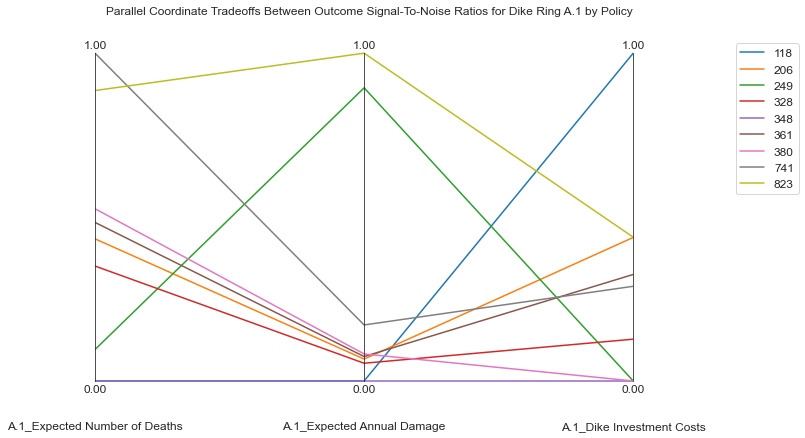

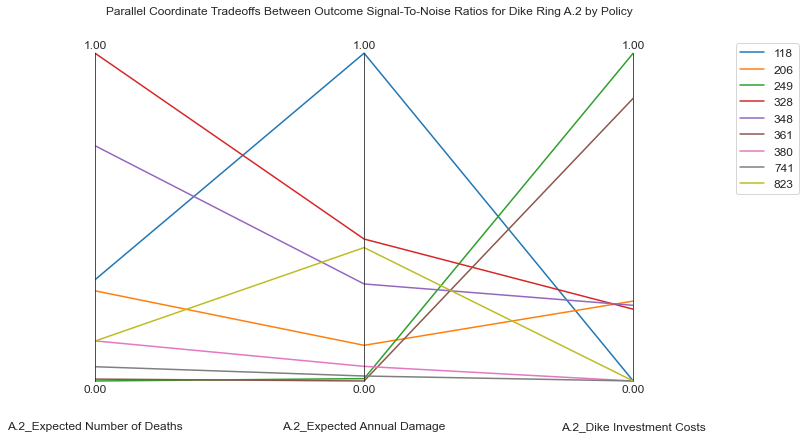

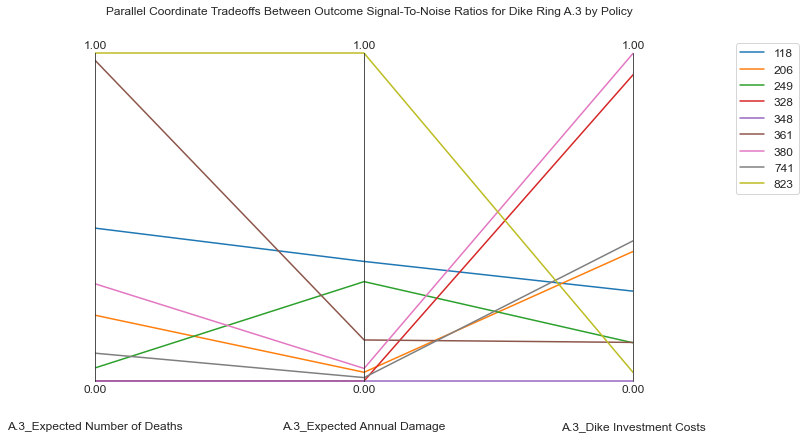

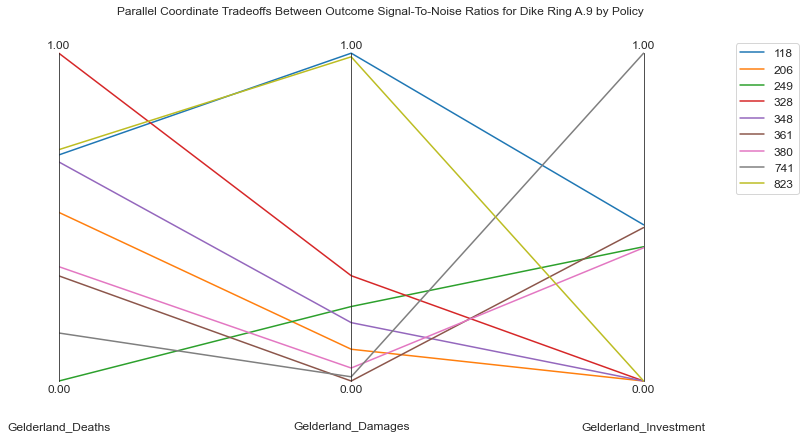

In [14]:
# Visualization of signal to noise ratio per policy, per dike rike and aggregate
data = scores
limits = parcoords.get_limits(data)

colors = sns.color_palette()


for i in range(3): #change to 5 for all dike rings 

        data = scores.loc[:, [f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Dike Investment Costs"
                               ]]
        data = ((data-data.min())/(data.max()-data.min()))
        
        limits = parcoords.get_limits(data,)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits, rot=0, fontsize=12)
        for j, (ind, row) in enumerate(data.reset_index().iterrows()):
            paraxes.plot(row.to_frame().T, label=int(row['index']), color=colors[j])
        paraxes.legend()
        plt.title(f"Parallel Coordinate Tradeoffs Between Outcome Signal-To-Noise Ratios for Dike Ring A.{i+1} by Policy",
                 loc="right", fontsize=12)
        plt.savefig(f"parcoords_tradeoffs A.{i+1}.png", dpi=300, bbox_inches='tight')
        
        plt.show()

data = scores.loc[:, ["Gelderland_Deaths", "Gelderland_Damages", "Gelderland_Investment"]]
data = ((data-data.min())/(data.max()-data.min()))
limits = parcoords.get_limits(data)
limits.loc[0, [f"Gelderland_Deaths", "Gelderland_Damages", "Gelderland_Investment"]] = 0

paraxes = parcoords.ParallelAxes(limits, rot=0, fontsize=12)
for i, (ind, row) in enumerate(data.reset_index().iterrows()):
    paraxes.plot(row.to_frame().T, label=int(row['index']), color=colors[i])
paraxes.legend()
plt.title(f"Parallel Coordinate Tradeoffs Between Outcome Signal-To-Noise Ratios for Dike Ring A.{i+1} by Policy",
                 loc="right", fontsize=12)
plt.savefig("parcoords_tradeoffs Gelderland.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

C:\Users\derka\AppData\Local\Temp/ipykernel_3768/985845255.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


# HeatMaps for Regret and Additional Visualization (including potential viable policies)

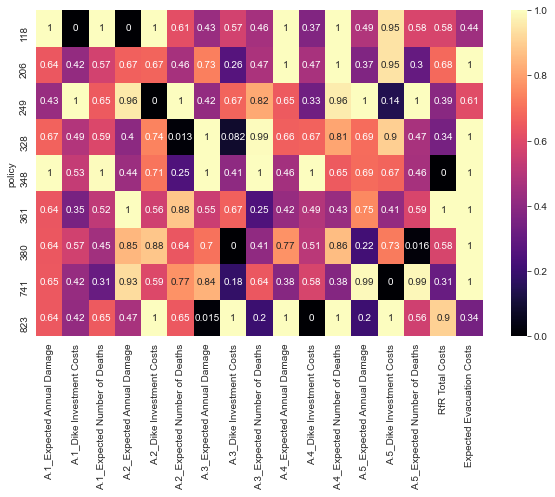

In [16]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='magma', annot=True)
plt.show()

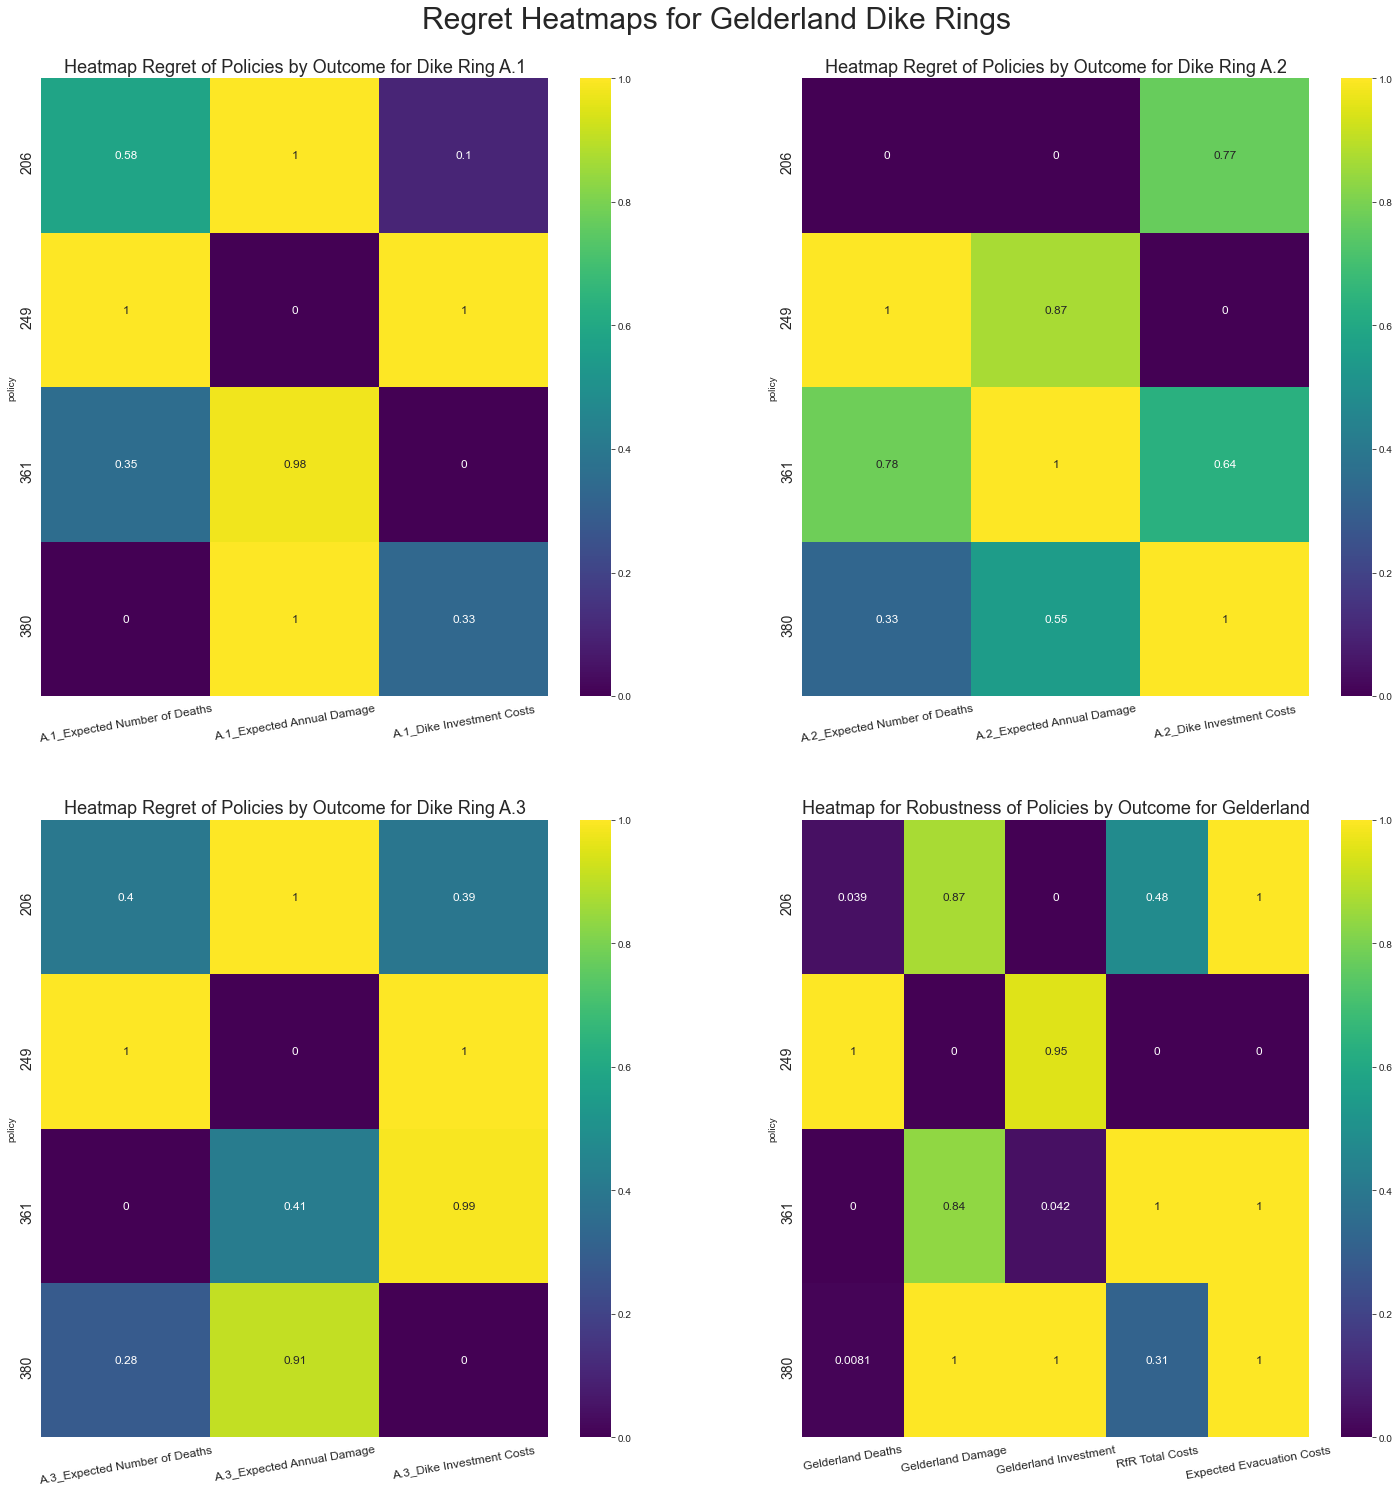

In [21]:
#splittiing up max_regret dataframe by dike ring
fig, axn = plt.subplots(2,2, figsize = (25, 25))
fig.suptitle("Regret Heatmaps for Gelderland Dike Rings", fontsize=30, y=0.92)

for i in range(3):
    max_regret_a = max_regret[[f'A.{i+1}_Expected Number of Deaths',
                             f'A.{i+1}_Expected Annual Damage',
                             f'A.{i+1}_Dike Investment Costs']].iloc[[1,2,5,6], :]
    max_regret_normalized = ((max_regret_a-max_regret_a.min())/(max_regret_a.max()-max_regret_a.min()))
    plt.subplot(2, 2, i+1)
    plt.title(f"Heatmap Regret of Policies by Outcome for Dike Ring A.{i+1}", fontsize=18)
    plt.yticks(fontsize=14, rotation=90)
    plt.xticks(fontsize=12, rotation=10)
    sns.heatmap(max_regret_normalized, cmap='viridis', annot=True, annot_kws={"fontsize": "large"})
    
#split by Gelderland-dike ring specific aggregates
max_regret_gelderland_agg = max_regret[['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths','A.3_Expected Number of Deaths']].sum(axis=1).to_frame(name='Gelderland Deaths')
max_regret_gelderland_agg['Gelderland Damage'] = max_regret['A.1_Expected Annual Damage'] + max_regret['A.2_Expected Annual Damage'] + max_regret['A.3_Expected Annual Damage']
max_regret_gelderland_agg['Gelderland Investment'] = max_regret['A.1_Dike Investment Costs'] + max_regret['A.2_Dike Investment Costs'] + max_regret['A.3_Dike Investment Costs']
max_regret_gelderland_agg[['RfR Total Costs', 'Expected Evacuation Costs']] = max_regret[['RfR Total Costs', 'Expected Evacuation Costs']]
max_regret_gelderland_agg = max_regret_gelderland_agg.iloc[[1,2,5,6], :]


max_regret_gelderand_agg_normalized = ((max_regret_gelderland_agg-max_regret_gelderland_agg.min())/
                                (max_regret_gelderland_agg.max()-max_regret_gelderland_agg.min()))
plt.subplot(2, 2, 4)
sns.heatmap(max_regret_gelderand_agg_normalized, cmap='viridis', annot=True, annot_kws={"fontsize": "large"})
plt.title(f"Heatmap for Robustness of Policies by Outcome for Gelderland", fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12, rotation=10)
fig.savefig("Heatmaps regret.png", dpi=300)

In [18]:
#make copy of evaluated policies
policies_to_evaluate_copy = policies_to_evaluate

NameError: name 'policies_to_evaluate' is not defined

In [ ]:
policies_to_evaluate_copy_df = pd.DataFrame(policies_to_evaluate_copy)

In [ ]:
x = experiments.drop(columns=['policy', *outcome_names, "model", "Unnamed: 0", "scenario"])

y_limit_deaths = np.quantile(outcomes_df["Gelderland_Deaths"],0.9)
y_limit_damages = np.quantile(outcomes_df["Gelderland_Damages"],0.9)

high_deaths = np.array([value > y_limit_deaths for value in outcomes_df["Gelderland_Deaths"]])
high_damages = np.array([value > y_limit_damages for value in outcomes_df["Gelderland_Damages"]])

prim_deaths = prim.Prim(x, high_deaths, threshold=0.5)
box_deaths = prim_deaths.find_box()
prim_damages = prim.Prim(x, high_damages, threshold=0.5)
box_damages = prim_damages.find_box()

In [ ]:
scens_in_box = experiments.iloc[box_deaths.yi].drop(columns=['policy', *outcome_names, "model", "Unnamed: 0", "scenario"])
scens_in_box.describe()

In [ ]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0],]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()